# CDP Competition 


## Imports

In [114]:
# standard libs
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
from IPython.core.debugger import set_trace

# plotting libs
import seaborn as sns

# geospatial libs
# from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon
import geopandas as gpd
import folium
import plotly.graph_objects as go
import plotly_express as px

# set in line plotly 
from plotly.offline import init_notebook_mode;
init_notebook_mode(connected=True)

print(os.getcwd())

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

SAVE_PATH = '/Users/xavier/Projets/Kaggle/CDP/Figures/'

/Users/xavier/Projets/Kaggle/CDP/CDP/notebook


## Data

### Import Data

In [109]:
# import corporate response data
cc_df = pd.read_csv('../../input/cdp-unlocking-climate-solutions/Corporations/Corporations Responses/Climate Change/2019_Full_Climate_Change_Dataset.csv')
ws_df = pd.read_csv('../../input/cdp-unlocking-climate-solutions/Corporations/Corporations Responses/Water Security/2019_Full_Water_Security_Dataset.csv')

In [3]:
# import cities response df
cities_df = pd.read_csv("../../input/cdp-unlocking-climate-solutions/Cities/Cities Responses/2020_Full_Cities_Dataset.csv")

In [4]:
# external data - import CDC social vulnerability index data - census tract level
svi_df = pd.read_csv("../../input/cdp-unlocking-climate-solutions/Supplementary Data/CDC Social Vulnerability Index 2018/SVI2018_US.csv")

In [5]:
# cities metadata - lat,lon locations for US cities
cities_meta_df = pd.read_csv("../../input/cdp-unlocking-climate-solutions/Supplementary Data/Simple Maps US Cities Data/uscities.csv")

# cities metadata - CDP metadata on organisation HQ cities
cities_cdpmeta_df = pd.read_csv("../../input/cdp-unlocking-climate-solutions/Supplementary Data/Locations of Corporations/NA_HQ_public_data.csv")

### Set up and Parameters

#### Check the structure

In [6]:
#len(cities_df['Question Number'].unique())
keys = [*cities_df]
keys

['Questionnaire',
 'Year Reported to CDP',
 'Account Number',
 'Organization',
 'Country',
 'CDP Region',
 'Parent Section',
 'Section',
 'Question Number',
 'Question Name',
 'Column Number',
 'Column Name',
 'Row Number',
 'Row Name',
 'Response Answer',
 'Comments',
 'File Name',
 'Last update']

In [7]:
index_RA = keys.index('Response Answer')
index_RA

14

In [8]:
cities_df['Questionnaire'].unique()

array(['Cities 2020'], dtype=object)

#### Remove all "unique" data

In [9]:
for key in keys:
    if len(cities_df[key].unique())==1:
        del cities_df[key]
        print('key deleted: {}'.format(key))

key deleted: Questionnaire
key deleted: Year Reported to CDP
key deleted: Last update


In [10]:
cities_df['Response Answer']

0         Question not applicable
1                             NaN
2                             NaN
3         Question not applicable
4         Question not applicable
                   ...           
869308                        NaN
869309                         No
869310                        NaN
869311                      12599
869312                        NaN
Name: Response Answer, Length: 869313, dtype: object

#### Describing the 'Response Answer' category:

In [11]:
len(cities_df['Response Answer'].unique())
len(cities_df['Question Number'])

869313

In [12]:
question_number = cities_df['Question Number'].unique()
question_number.sort()


# Preprocessing

## Select numerical and yes/no question type

### Numerical

In [13]:
def RepresentsFloat(s):
    try: 
        float(s)
        return True
    except ValueError:
        return False

In [14]:
numerical_question = []

for number in question_number:
    print(number)
    i=0
    check = False
    while check==False:
        s = str(cities_df[cities_df['Question Number'] == number]['Response Answer'].iloc[i])
        
        if s!='nan':
            check = RepresentsFloat(s)
            break
        i+=1
        
    if check:
        print(float(cities_df[cities_df['Question Number'] == number]['Response Answer'].iloc[0]))
        print(number)
        print(cities_df[cities_df['Question Number'] == number]['Question Name'].iloc[0])
        print(len(cities_df[cities_df['Question Number'] == number]['Response Answer'].unique()))
        print(type(cities_df[cities_df['Question Number'] == number]['Response Answer'].iloc[0]))
        print('\n \n \n')
        numerical_question.append(number)
    print(check)

0.1
False
0.2
False
0.3
False
0.4
False
0.5
2015.0
0.5
Please provide details of your city’s current population. Report the population in the year of your reported inventory, if possible.
1045
<class 'str'>

 
 

True
0.6
1219.67
0.6
Please provide further details about the geography of your city.
541
<class 'str'>

 
 

True
1.0
False
1.0a
False
1.1
False
1.2
False
1.3
False
1.4
False
1.5
False
1.6
False
1.7
False
10.0
False
10.1
False
10.11
False
10.12
False
10.13
False
10.14
21.0
10.14
Please provide city-wide average air pollution metrics from the monitoring sites within your city for the most recent three years.
794
<class 'str'>

 
 

True
10.15
False
10.2
False
10.3
False
10.4
nan
10.4
Please provide the total fleet size and number of vehicle types for the following modes of transport.
1495
<class 'float'>

 
 

True
10.5
False
10.6
False
10.7
False
10.7a
False
10.8
False
10.9
False
11.0
False
11.1
False
12.0
False
12.0a
False
12.1
2019.0
12.1
What is the per capita meat and dai

In [15]:
numerical_question

['0.5', '0.6', '10.14', '10.4', '12.1', '14.1', '8.1']

In [16]:
numerical_question

['0.5', '0.6', '10.14', '10.4', '12.1', '14.1', '8.1']

## Data validation

First let's have an example for the first question and set up the visualization

### City Population

In [17]:
cdf = cities_df[cities_df['Question Number'] == numerical_question[0]]
resp = np.asarray(cdf['Response Answer'].astype(np.float))

In [18]:
np.nanmax(resp)

1383432134.0

In [19]:
perc_max = np.nanpercentile(resp,99)
resp = resp[resp>2100]
range_hist = [np.min(resp), perc_max]

Text(0.5, 0, 'City Population')

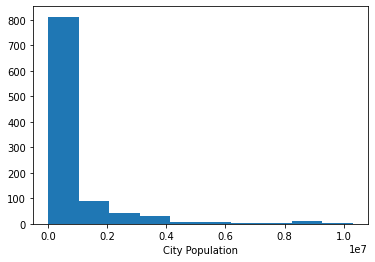

In [20]:
plt.hist(resp, range=range_hist)
plt.xlabel('City Population')

### City-wide average air pollution metrics
Please provide city-wide average air pollution metrics from the monitoring sites within your city for the most recent three years.

In [21]:
num = numerical_question[2]
cdf = cities_df[cities_df['Question Number'] == num]
question_name = cdf['Question Name'].iloc[0]
print(question_name)
cdf['Response Answer'].where(cdf['Response Answer']!='Question not applicable').dropna().iloc[0:10]

Please provide city-wide average air pollution metrics from the monitoring sites within your city for the most recent three years.


10                                                     21
220                                                  Etat
445                                                    33
966                                                    No
1038                                                 2019
1065                                                   18
1231                                                 7.87
1524                                                  Yes
1792                                                   20
1975    https://www.city.yokohama.lg.jp/kurashi/machiz...
Name: Response Answer, dtype: object

In [22]:
num

'10.14'

In [23]:
list_resp = []
for i in cdf['Response Answer']:
    if RepresentsFloat(i):
        list_resp.append(np.float(i))
resp = np.asarray(list_resp)

In [24]:
print(np.nanmin(resp))
print(np.nanmax(resp))
print(np.nanpercentile(resp, 99))

0.0
46313.0
2020.0


In [25]:
resp = resp[resp<2000]

Text(0.5, 1.0, 'Please provide city-wide average air pollution metrics from the monitoring sites within your city for the most recent three years.')

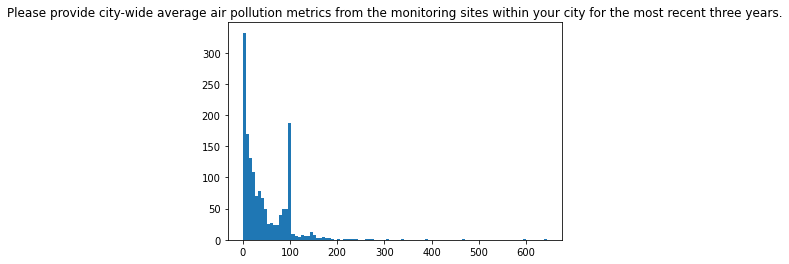

In [26]:
plt.figure()
plt.hist(resp, bins=100)
plt.title(question_name)
#plt.close()

### All other numerical questions from the selection are the city-wide average pollution

In [27]:
num = numerical_question[6]
question_name = cdf['Question Name'].iloc[0]
print(question_name)
cdf['Response Answer'].where(cdf['Response Answer']!='Question not applicable').dropna().iloc[0:10]

Please provide city-wide average air pollution metrics from the monitoring sites within your city for the most recent three years.


10                                                     21
220                                                  Etat
445                                                    33
966                                                    No
1038                                                 2019
1065                                                   18
1231                                                 7.87
1524                                                  Yes
1792                                                   20
1975    https://www.city.yokohama.lg.jp/kurashi/machiz...
Name: Response Answer, dtype: object

## Investigation of yes/no questions

In [28]:
bool_question = []

for number in question_number:
    i=0
    cdf = cities_df[cities_df['Question Number'] == number]['Response Answer']
    check = cdf.unique()
    
    if 'yes' in check or 'Yes' in check and len(check)<30:
        if 'no' in check or 'No' in check:
            bool_question.append(number)
            print(check)

['Question not applicable' 'Yes' nan 'No']
['Yes' 'Question not applicable' nan 'Do not know' 'No']
['No' 'Yes' nan 'Do not know']
['Question not applicable' nan 'Yes' 'Não aplicável' 'Do not know' 'No'
 'Se ha gestionado y nunca se ha permitido, por tener calles nacionales en el territorio'
 'Existen instrumentos regulatorios (leyes y reglamentos) a nivel subnacional (Estado de Jalisco) y nacional que restringen el acceso de vehículos según su peso y altura.'
 'It will be provided in Klaipeda city municipality strategy development plan of 2021-2030'
 'En el Mercado Unicachi llegan camiones de gran capacidad conteniendo producos de primera necesidad, cuya área se encuentra restringida.'
 'There is no loading/unloading restricted zone for logistics in Kaohsiung, but there are regulations for prohibiting the driving of tractor trailers and heavy trucks (divided into 35 tons, 30 tons, 25 tons, 21 tons, 20 tons, 15 tons, 11 tons, 8.8 tons, 5.5 tons and 3.5 tons), as well as Class A and Cla

In [29]:
bool_question

['1.5',
 '10.11',
 '10.7',
 '10.8',
 '14.2',
 '2.3',
 '4.14',
 '5.2',
 '5.3',
 '5.5a',
 '6.14',
 '6.16']

### Describe to what extent the planning process is transparent and open

In [30]:
def first_view(cities_df, num):
    print(num)
    cdf = cities_df[cities_df['Question Number'] == num]
    question_name = cdf['Question Name'].iloc[0]
    print(question_name)
    value = cdf['Response Answer'].where(cdf['Response Answer']!='Question not applicable').dropna()#.iloc[0:10]
    print(value.iloc[0:10])
    print(len(value))
    return cdf

In [31]:
num = bool_question[0]
for num in bool_question:
    cdf = first_view(cities_df, num)
    print('\n \n')

1.5
Please describe to what extent the planning process is transparent and open.
858      Yes
1606     Yes
1754     Yes
2874     Yes
13775    Yes
14832    Yes
20278    Yes
20840     No
22666    Yes
25954    Yes
Name: Response Answer, dtype: object
197

 

10.11
Does your city collect air quality data?
533              Yes
8911             Yes
9445             Yes
18326            Yes
24712            Yes
32180            Yes
35288    Do not know
36675             No
53900    Do not know
55007            Yes
Name: Response Answer, dtype: object
111

 

10.7
Do you have a low or zero-emission zone in your city? (i.e. an area that disincentivises fossil fuel vehicles through a charge, a ban or access restriction)
945       No
2080      No
2590      No
5194      No
6420      No
7447      No
8267      No
10335    Yes
11044     No
12002     No
Name: Response Answer, dtype: object
498

 

10.8
Do you have a loading / unloading Restricted Zone for Logistics? If yes, please provide more detail 

In [32]:
cdf['Response Answer'].unique()

array(['Question not applicable', nan, 'No', 'Yes', 'Do not know',
       "Emission reduction activities which the City of Melbourne undertake are captured under the activity data reported under the federal governmnent's National Greenhouse and Energy Reporting (NGER) scheme which make up the national accounts. The City of Melbourne is also a carbon neutral organisation under the federal governmnets climate active program and through this we purchase a mix of offsets, international offsets (which comprise most of our offsets by volume) do not contribute to NDCs, whilst  Australian Carbon Credit Units do. Our activity data/emissions should be captured within the national accounts, and we report them via NGER.",
       "ClimateThe goal of the environment protection authorities is that the concentration of greenhouse gases shall be stabilized at a level that will prevent dangerous, man-made impacts on the climate system.Renewable energyHydroelectric power, wind power, and bioenergy are im

In [33]:
len(cdf['Response Answer'].where(cdf['Response Answer']!='Question not applicable').dropna())

87

## New approach - Parent Section

Focusing on Parent Section

In [49]:
def get_top_n_bigram(corpus, n=None, ngram_range_dim=2):
    vec = TfidfVectorizer(ngram_range=(ngram_range_dim,ngram_range_dim), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_words(corpus, n=None):
    vec = TfidfVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

colors= ['#003f5c','#2f4b7c','#665191','#a05195','#d45087','#f95d6a','#ff7c43','#ffa600','#fcca46','#a1c181','#619b8a','#386641']

In [50]:
[*cities_df]

['Account Number',
 'Organization',
 'Country',
 'CDP Region',
 'Parent Section',
 'Section',
 'Question Number',
 'Question Name',
 'Column Number',
 'Column Name',
 'Row Number',
 'Row Name',
 'Response Answer',
 'Comments',
 'File Name']

In [93]:
list_parent_section = cities_df['Parent Section'].unique()
#Removing the nan
list_parent_section = list_parent_section[1::]

### City-wide Emissions

In [123]:
def select_question(df_parent, quest):
    return df_parent[df_parent['Question Name']==quest]

def select_parent_section(cities_df, parent_name):
    return cities_df[cities_df['Parent Section'] == parent_name]

def define_answer(question, cwe):
    select = select_question(cwe, question)
    answer = select['Response Answer']
    #print(quest)
    #print(len(answer.unique()))
    if len(answer.unique())<30:
        print(quest)
        print(answer.unique())
        return answer
    else:
        return []

def plot(answer, color, savefig_fullpath):
    answer.value_counts().plot.pie(textprops={'color':"w"},pctdistance=0.7,autopct='%.2f%%',figsize=(10,10),colors=colors, labels=None)
    plt.title(question,fontsize=12,ha='left')
    plt.legend(labels=answer.value_counts().index, loc="best",bbox_to_anchor=(1, 0.25, 0.5, 0.5))
    plt.savefig(savefig_fullpath, dpi=350)
    plt.show()

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['HFCs' 'CO2' 'N20' 'PFCs' 'Question not applicable' 'CH4' 'NF3' nan 'SF6']


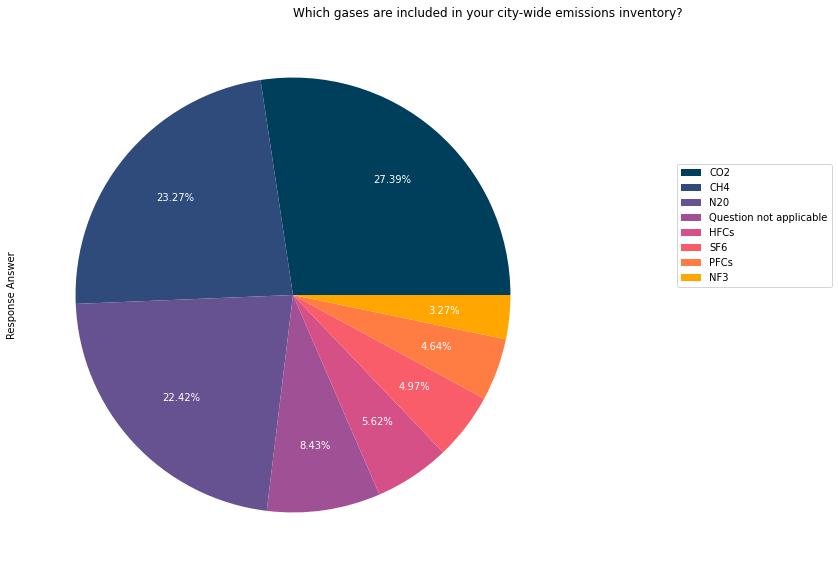

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Question not applicable' 'Yes' nan 'Not intending to undertake'
 'Do not know' 'Intending to undertake in the next 2 years' 'In progress']


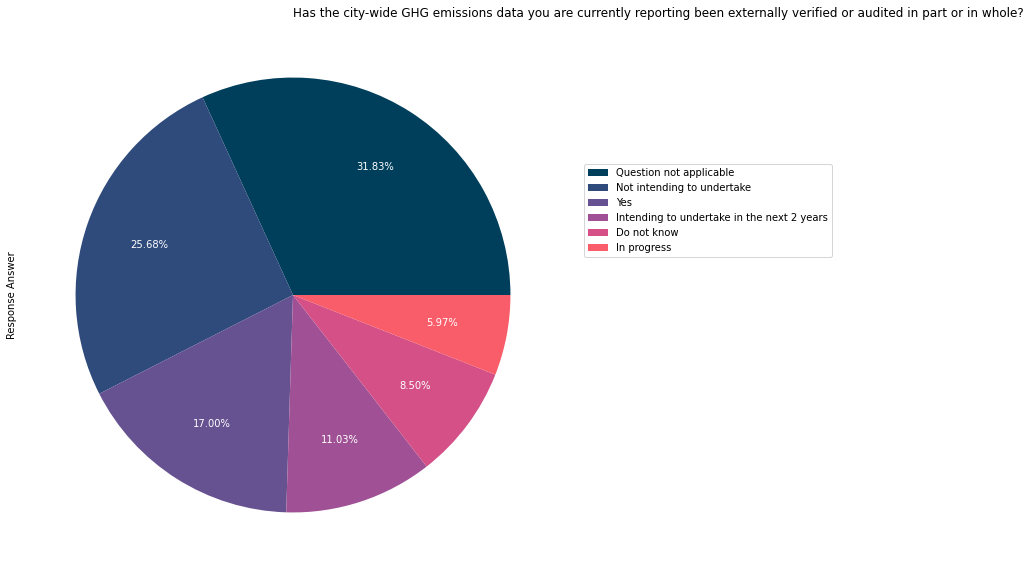

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['No' 'Question not applicable' 'Yes' 'Do not know' nan]


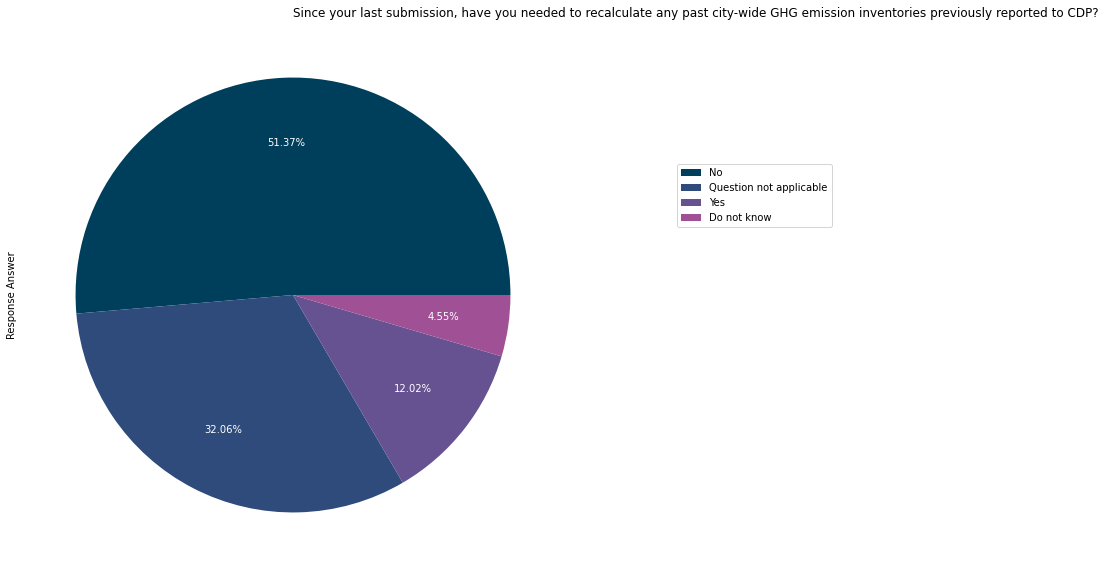

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Yes' 'In progress' nan 'Intending to undertake in the next 2 years'
 'Not intending to undertake']


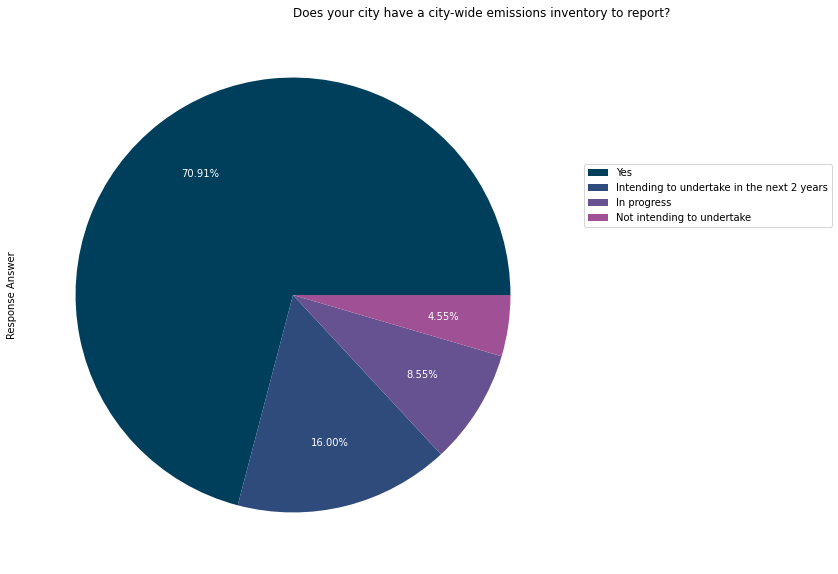

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Question not applicable'
 'No – I am unable to report in the CRF format, use the GPC format'
 'Yes – I will use the CRF format' nan]


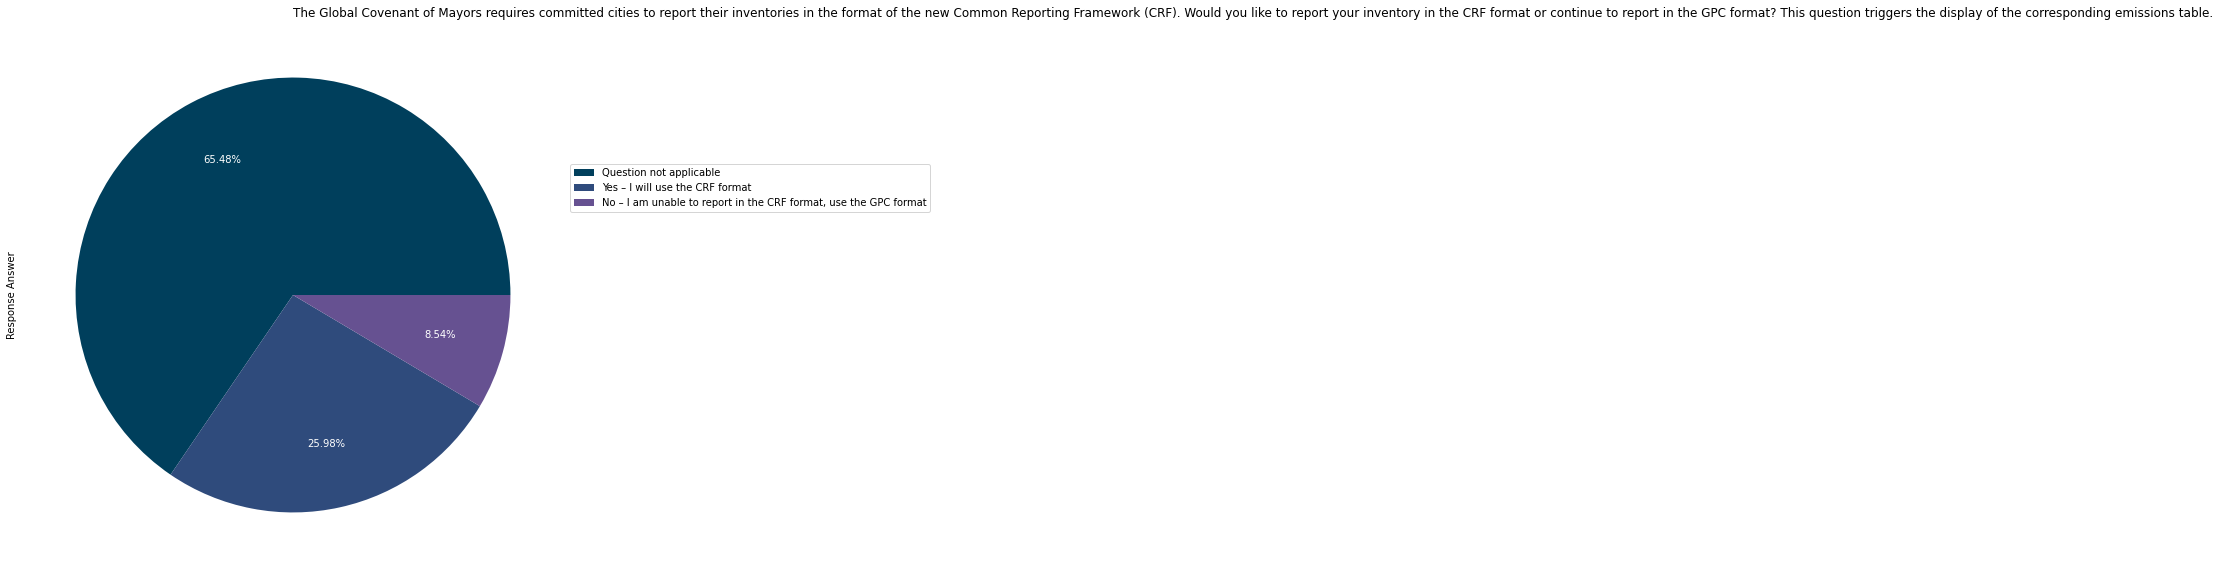

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Question not applicable' 'Yes' 'Do not know' nan 'Not applicable'
 "As part of the City's upcoming carbon neutrality plan (CAP), our consultant will research and provide recommendations for developing green businesses in the City and helping grow a green economy."
 "They work together with every other city department in the development of the city's Climate Action Plan and Sustainable Development Plan, to be launched in the end of 2020."
 'No'
 'The Enterprise and Investment Department leads the City’s green economy work and is the custodian of the City’s Invest Cape Town campaign. The City’s respec

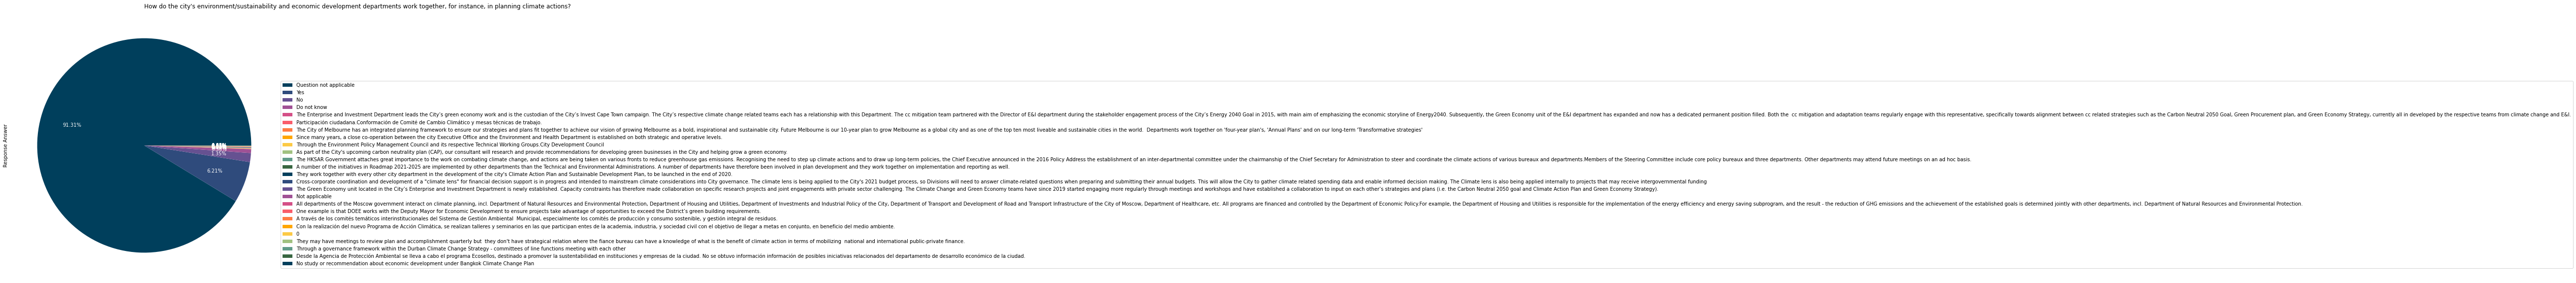

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Question not applicable' nan 'No' 'Yes' 'Do not know'
 "Emission reduction activities which the City of Melbourne undertake are captured under the activity data reported under the federal governmnent's National Greenhouse and Energy Reporting (NGER) scheme which make up the national accounts. The City of Melbourne is also a carbon neutral organisation under the federal governmnets climate active program and through this we purchase a mix of offsets, international offsets (which comprise most of our offsets by volume) do not contribute to NDCs, whilst  Australian Carbon Credit Units do. Our activity 

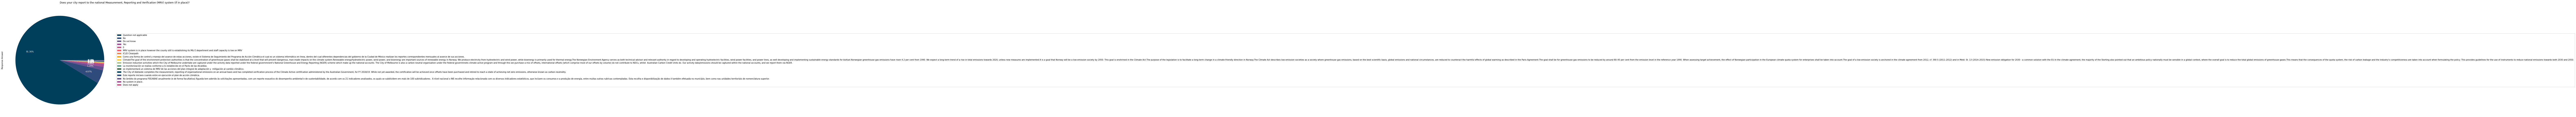

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Yes' 'Intending to undertake in the next 2 years' nan 'In progress'
 'Do not know' 'Not intending to undertake']


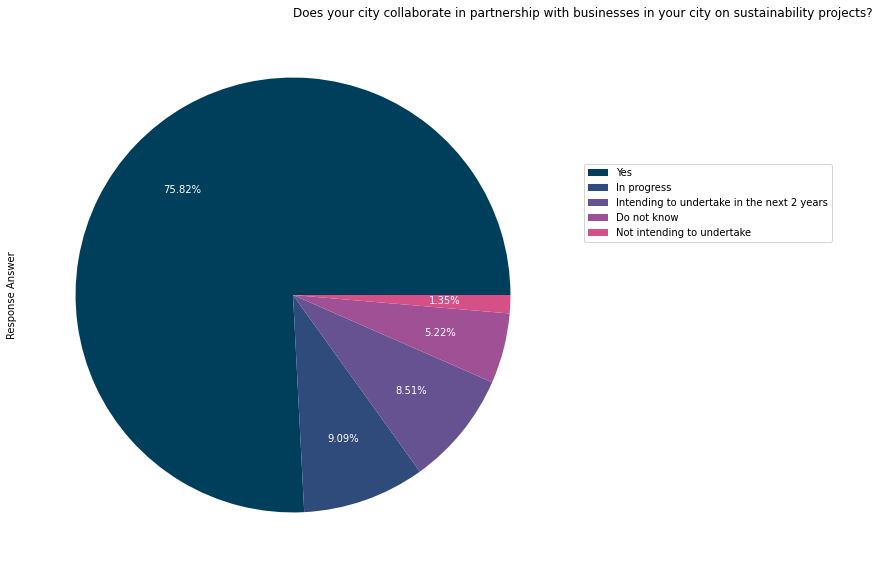

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Question not applicable' 'Yes' nan 'No']


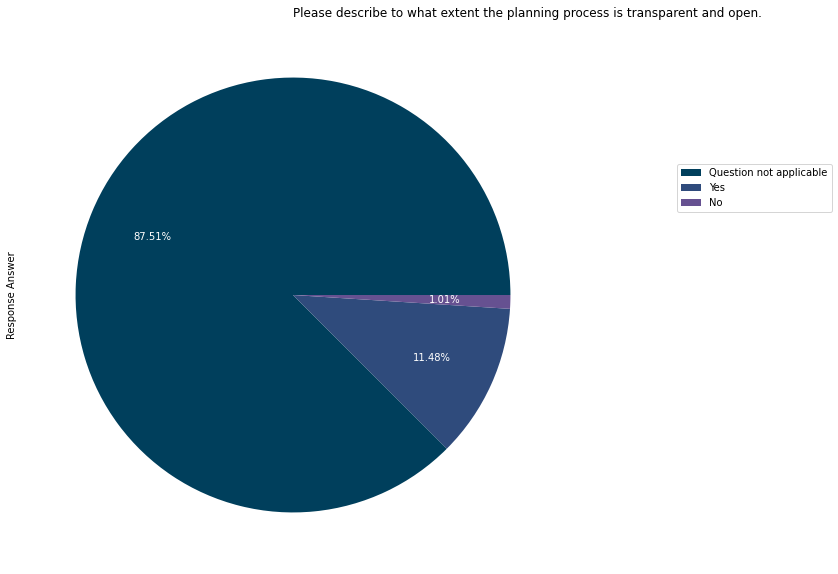

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Question not applicable' nan
 'The letter from the mayor for the Green Climate Cities (GCC) program has not yet been made'
 'Not applicable'
 'The City of Stockholm does not participate in the Green Climate Cities program.'
 'O município de Campinas ainda não ativamente participa do Projeto Green Climate Cities do ICLEI. A carta será providenciada oportunamente.'
 'Não houve articulação interna para efetivar a participação de São José dos Campos, nesse momento, no programa Green Climate Cities. De qualquer forma, há interesse da equipe técnica conhecer melhor essa metodologia'
 'The City has not yet

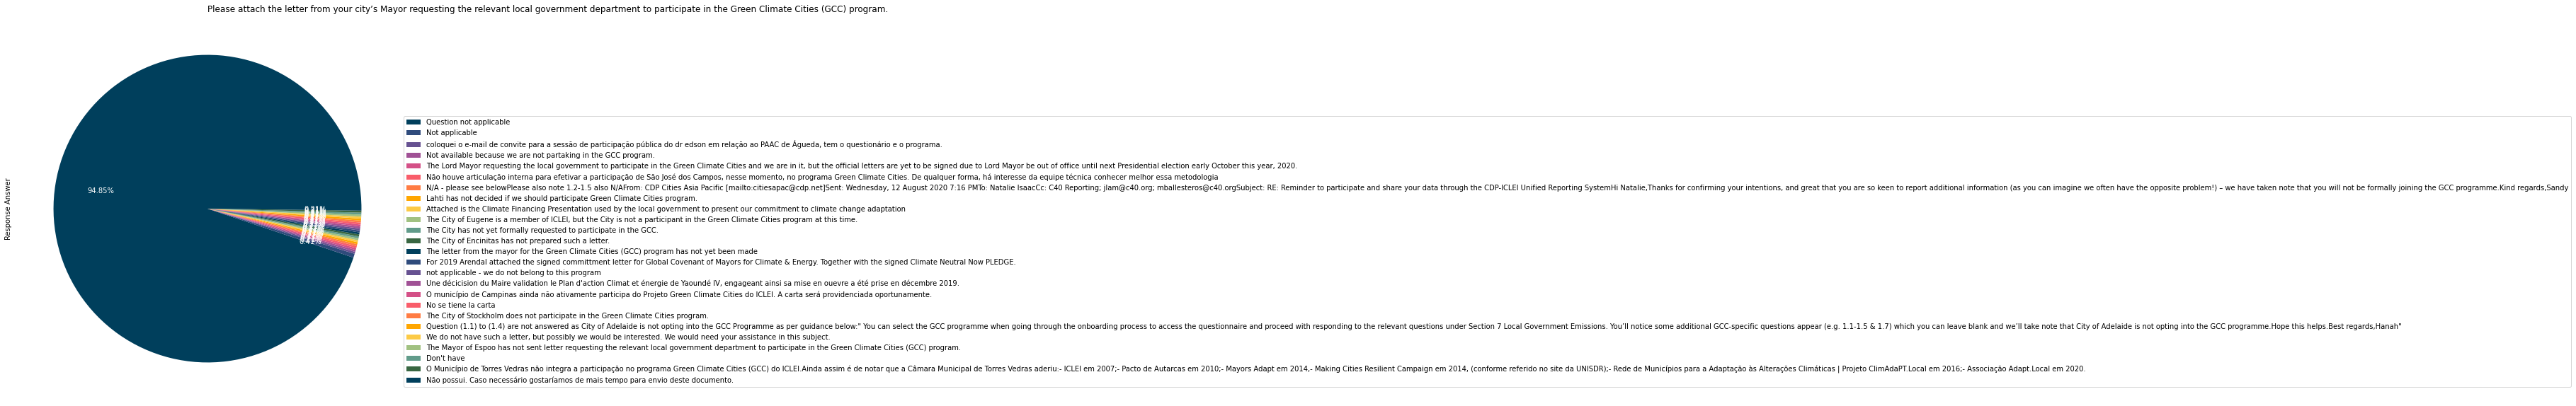

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Yes' 'In progress' 'Intending to incorporate in the next 2 years' nan
 'Not intending to incorporate' 'Do not know']


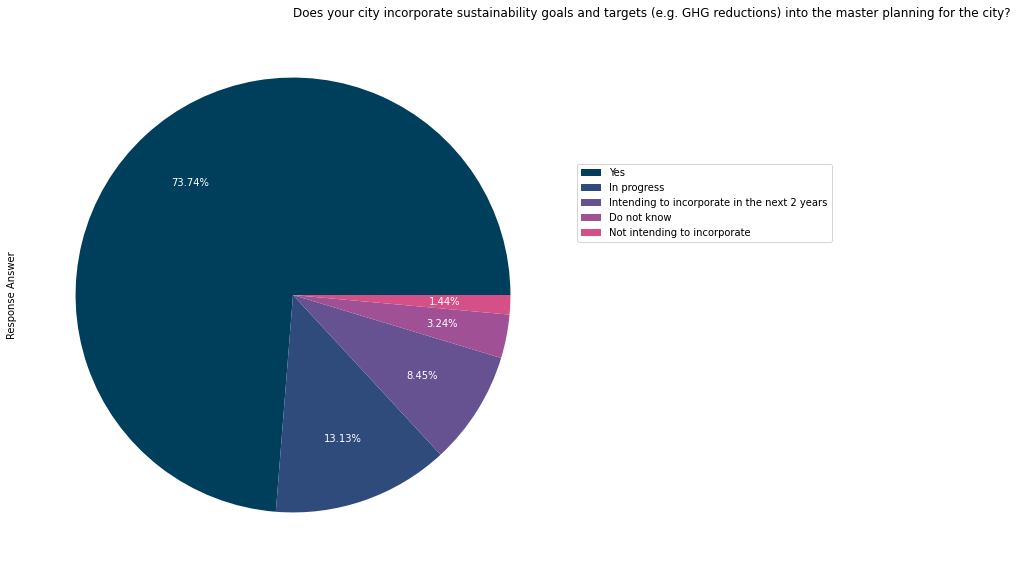

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Yes' 'Intending to undertake in next 2 years' nan 'In progress'
 'Not intending to undertake']


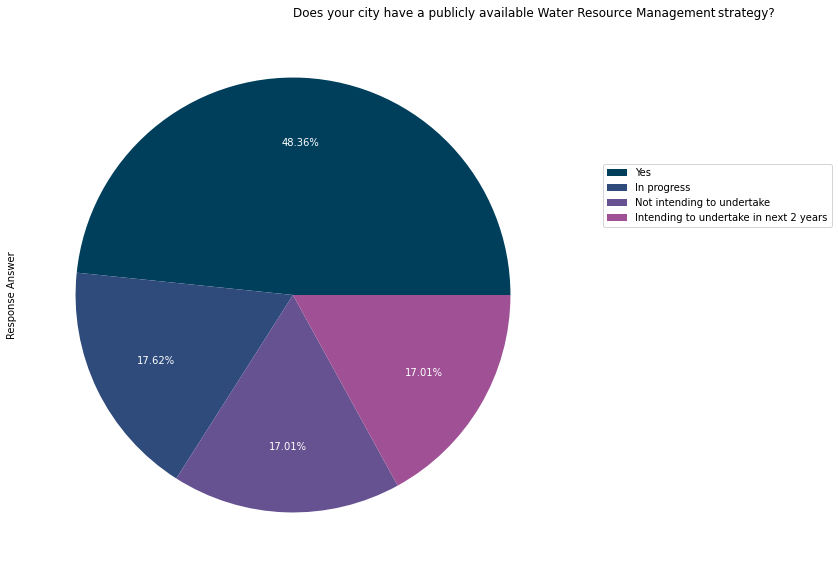

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Yes' nan 'No' 'Do not know']


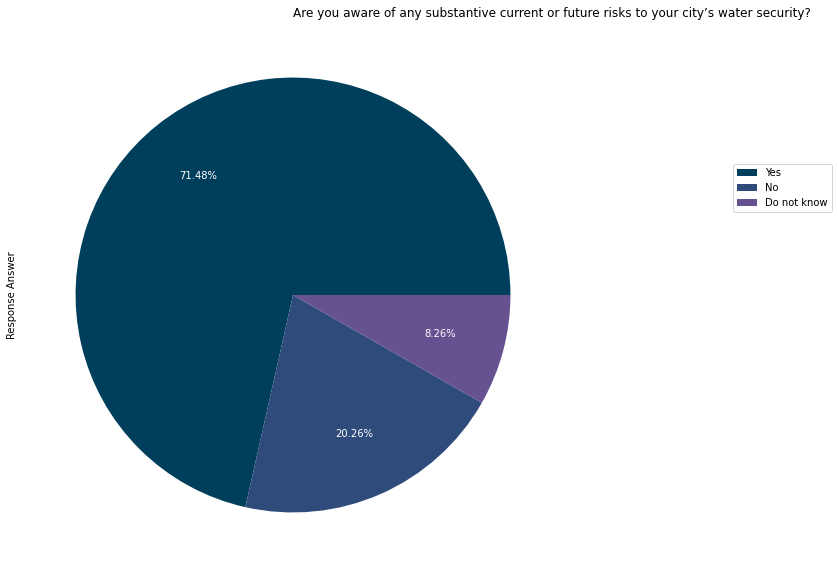

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Question not applicable' 'N2O' 'CH4' 'CO2' 'HFCs' 'SF6' 'PFCs' nan 'NF3']


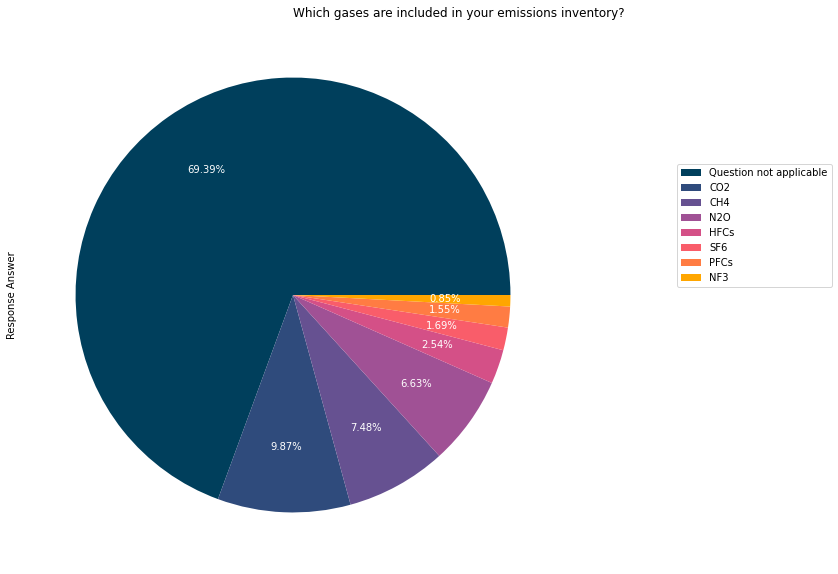

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Question not applicable'
 'Departments, entities or companies over which operational control is exercised'
 'Other, please specify: Scope 1 and scope 2 emissions for the direct operations of the local authority: its buildings (heat and power); street lighting electricity; vehicle fleet fuel; scope 3 emissions associated with scope 1 and 2 emissions, and for staff business travel'
 'Departments, entities or companies over which financial control is exercised'
 nan 'Other, please specify: Município de Torres Vedras'
 'Other, please specify: The City assigned a value of GHG emissions per person and the

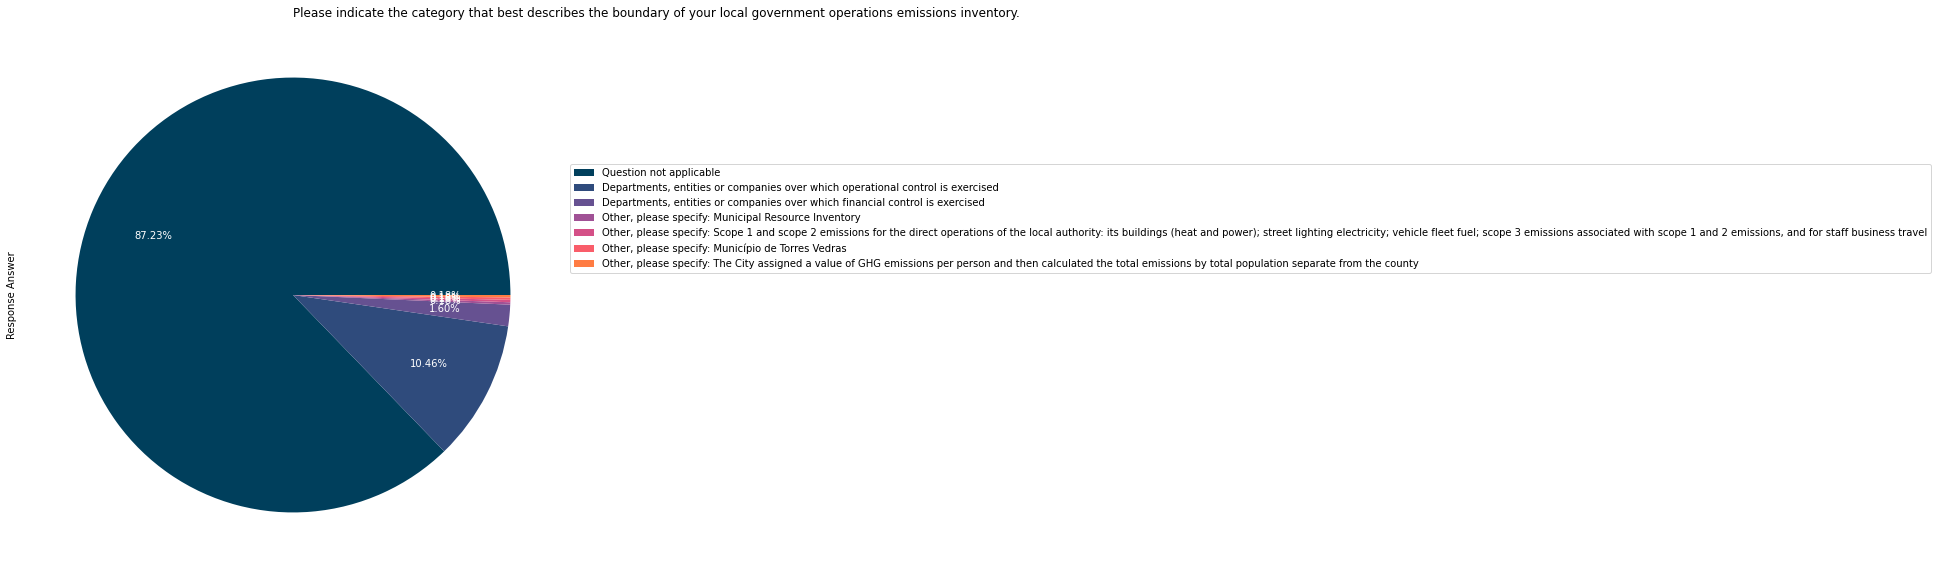

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Question not applicable' 'Not required by national authorities' nan
 'Sería demasiado costoso y no se disponen de medios, por eso no se realiza de forma voluntaria.'
 'Low data quality'
 'Lack of funding/resources. Assessed as insignificant.'
 'Lack of funding / resources'
 "Scope 3 emissions are for trash incineration - estimated to be 2% of Town's municipal emissions"
 'Lack of data' 'Lack of knowledge / capacity'
 'At this moment in time the City of Tshwane will only identify scope 3 emissions on a qualitative level. The aim is to identify the most material and measurable scope 3 emissions from t

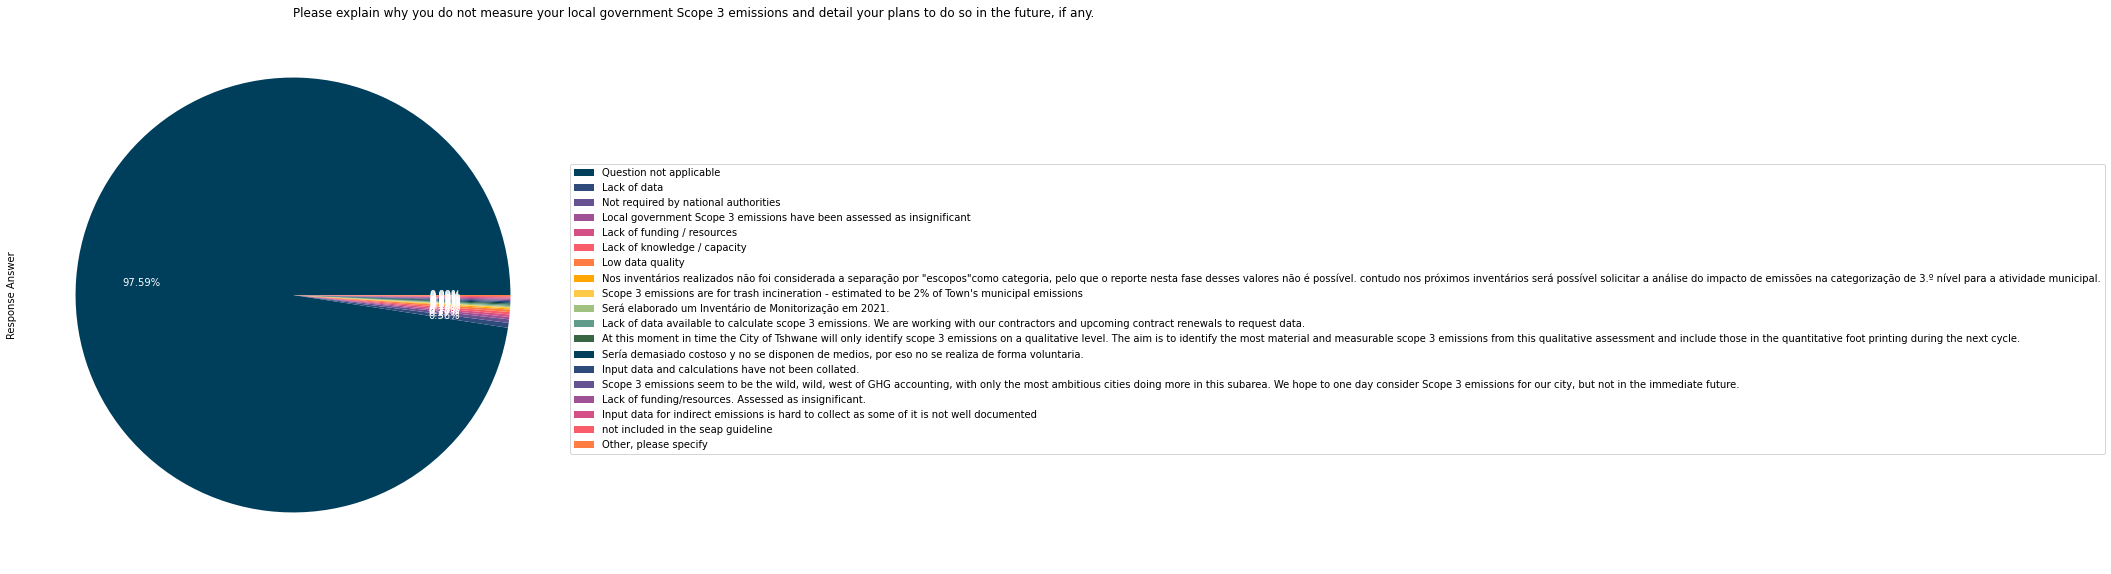

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Question not applicable'
 'Los gobiernos de la ciudad (o cualquier gran organización) deben valorar el hecho de una verificación o auditoria externas de sus esfuerzos enreducir emisiones.  Esto les puede conferir niveles más altos de control de calidad / garantía de calidad. La habilidad de recurrir a información verificada le puede otorgar al gobierno una poderosa herramienta en esfuerzos para influenciar las leyes o reglamentaciones en otras áreas del gobierno o con otra comunidad de stakeholders.'
 'Lack of funding / resources'
 'The city does not use consultants but own expertise with high compe

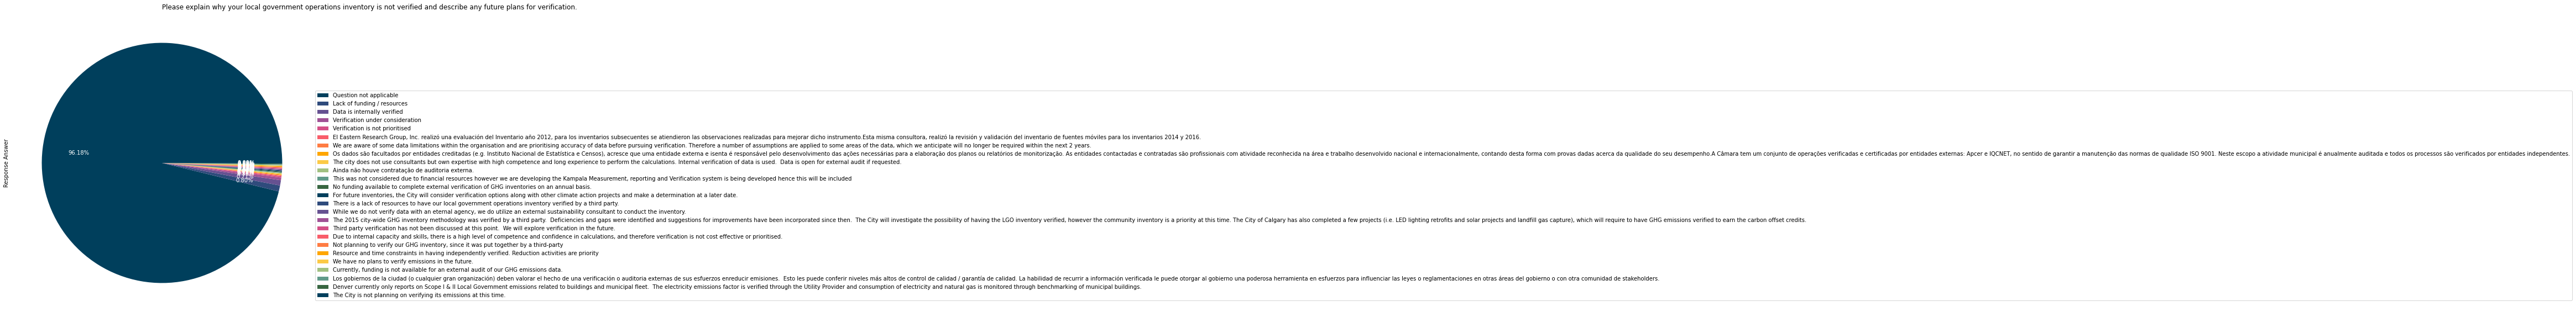

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Question not applicable' 'Intending to undertake in the next 2 years'
 'Yes' 'In progress' nan 'Not intending to undertake']


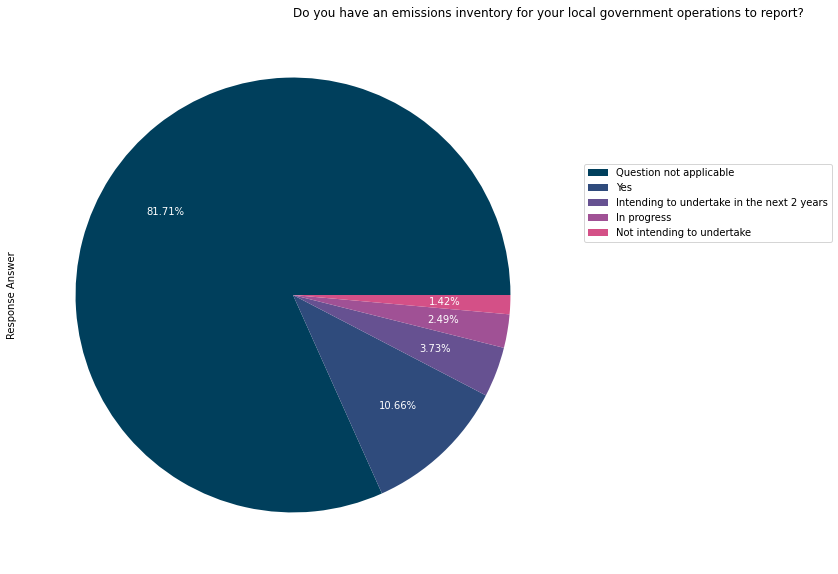

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Question not applicable' 'Yes' nan
 'Intending to undertake in the next 2 years' 'Not intending to undertake'
 'In progress']


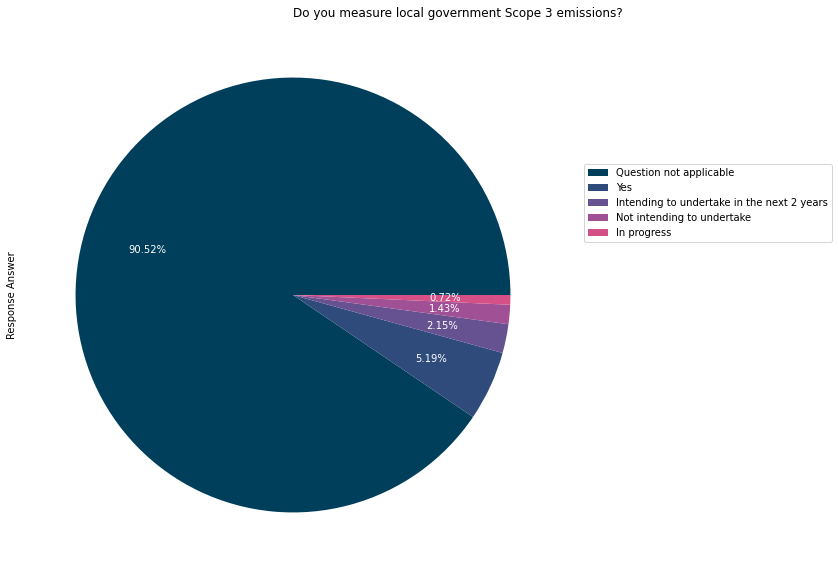

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Question not applicable' 'Yes' 'Not intending to undertake'
 'Do not know' 'In progress' nan
 'Intending to undertake in the next 2 years']


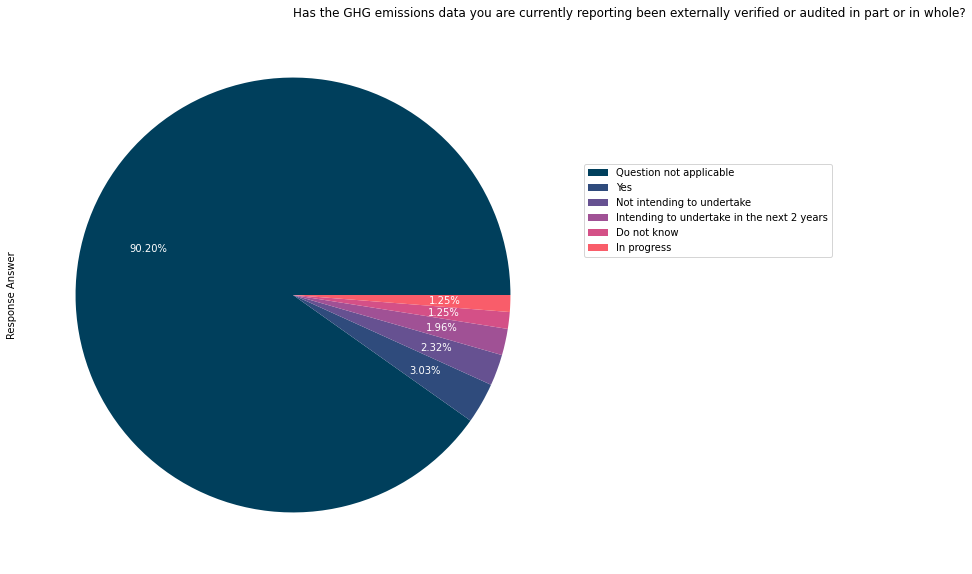

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Yes' nan 'Do not know' 'In progress'
 'Intending to undertake in the next 2 years' 'Not intending to undertake']


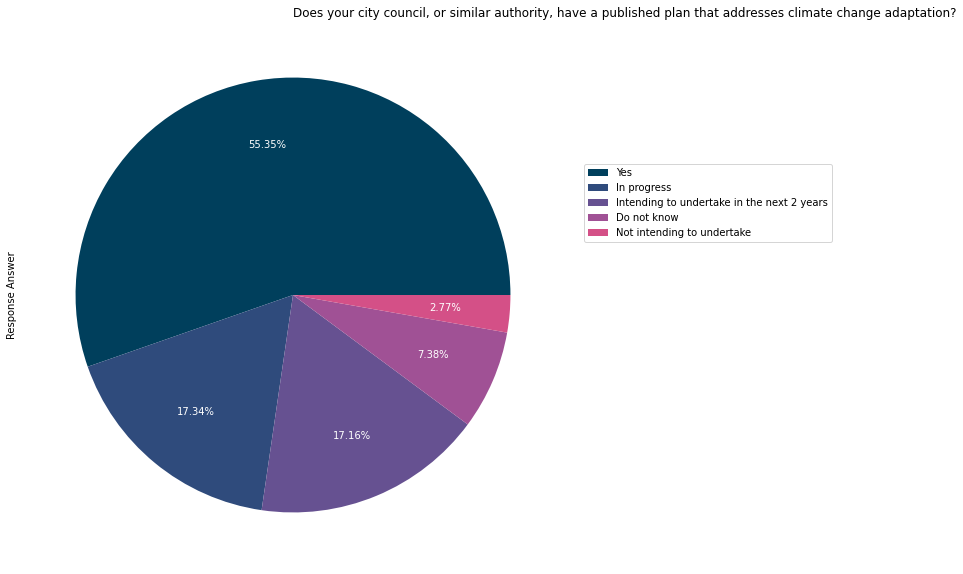

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Lack of resources / funding' 'Question not applicable' nan
 'Adaptation is covered in the city plans' 'Other, please specify'
 'El estudio denominado Estudio de Mitigación de Cambio Climático integrado dentro del Programa de Ciudades Sostenibles y Competitivas de FINDETER, en el marco de la Iniciativa Ciudades Emergentes y Sostenibles del BID, formulado en el año 2016, plantea dentro de sus objetivos el seleccionar quince (15) medidas de reducción de Gases de Efecto Invernadero en torno a los ejes de eficiencia energética, energías renovables y optimización de los recursos, los cuales se convierten 

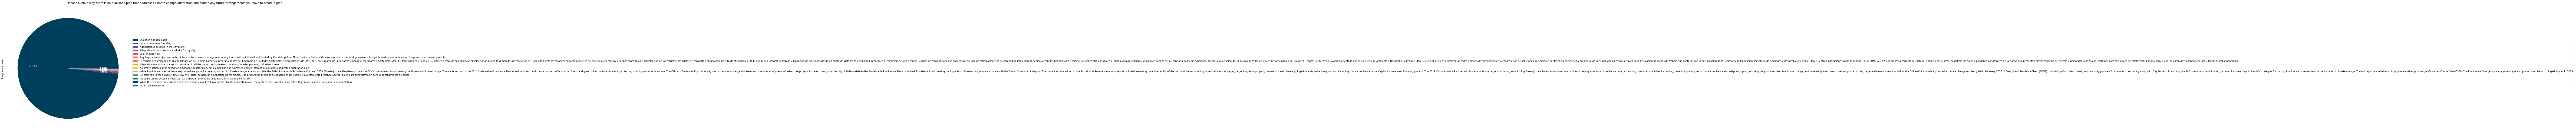

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Do not know' nan 'No' 'Yes']


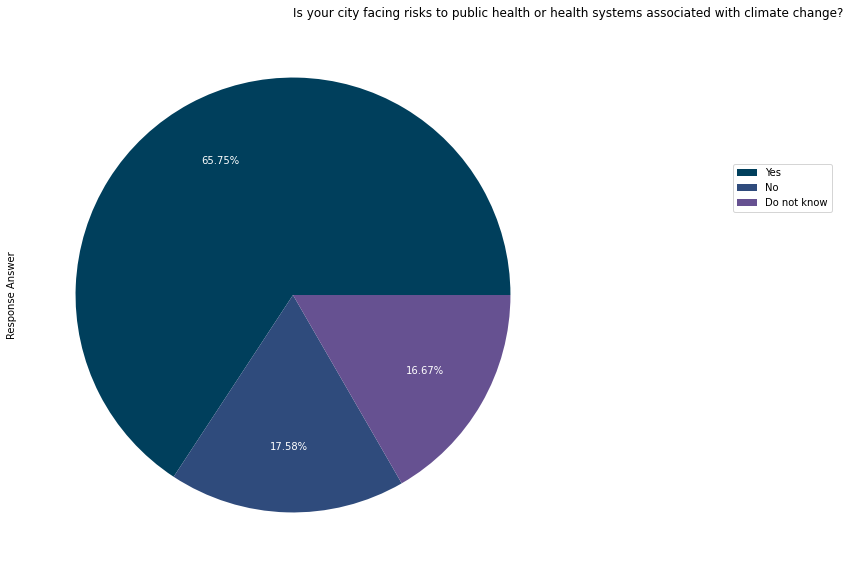

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Question not applicable' 'Lack of resources / funding' nan
 'Other, please specify'
 'Currently not a statutory requirement for local authorities.'
 'Finnish Meteorological Institute (FMI) has worked together with City of Helsinki and they have recognized weather and climate risks in the City of Helsinki. According to FMI, the same climate related risks are valid in the Porvoo area as Porvoo is situated only 50km east of Helsinki.  Therefore, we use the same document in order to indentify the risks that climate change brings to the area.'
 'Não há recursos financeiros para avaliação das vulnerabilid

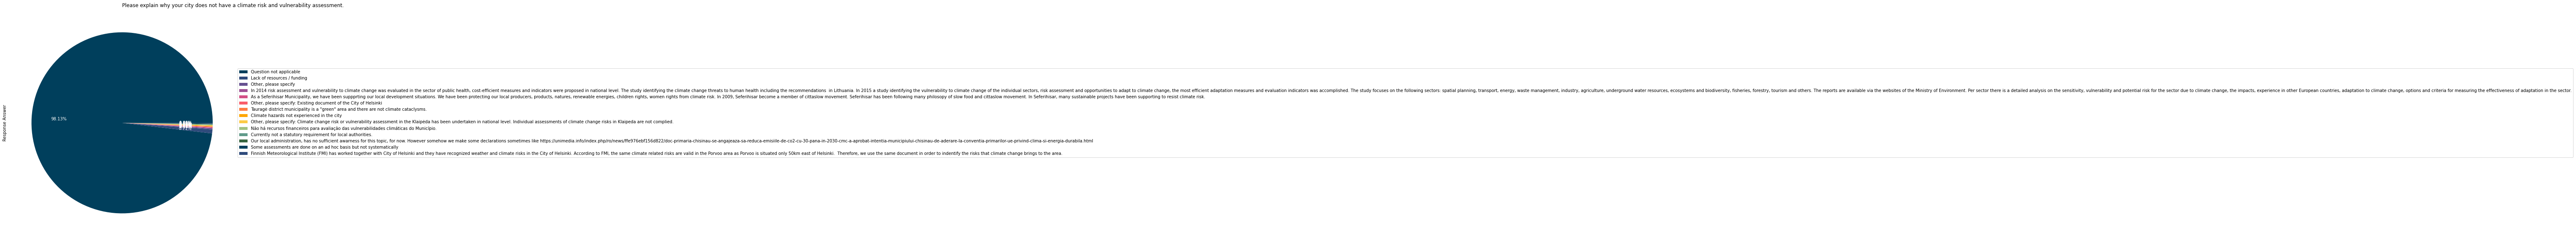

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Yes' 'Intending to undertake in the next 2 years' 'In progress' nan
 'Do not know' 'Not intending to undertake']


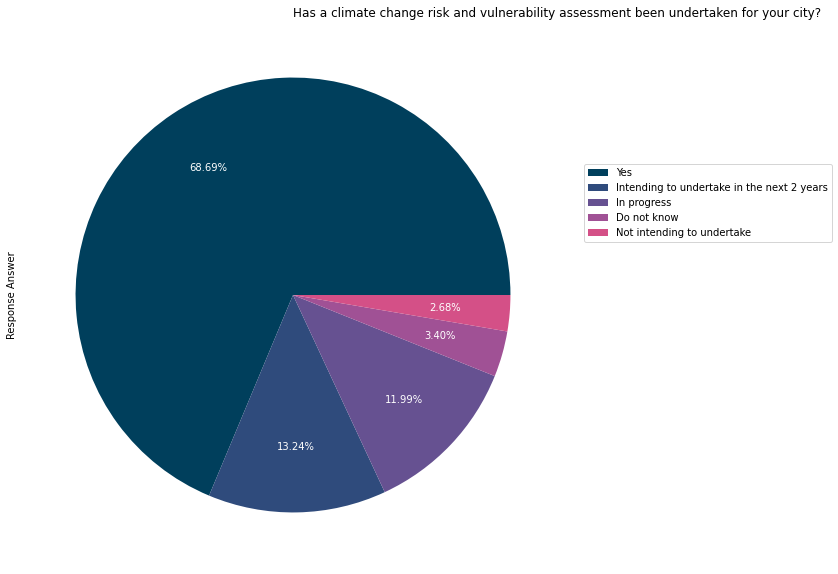

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Base year emissions (absolute) target' 'Base year intensity target' nan
 'Baseline scenario (business as usual) target' 'No target'
 'Fixed level target']


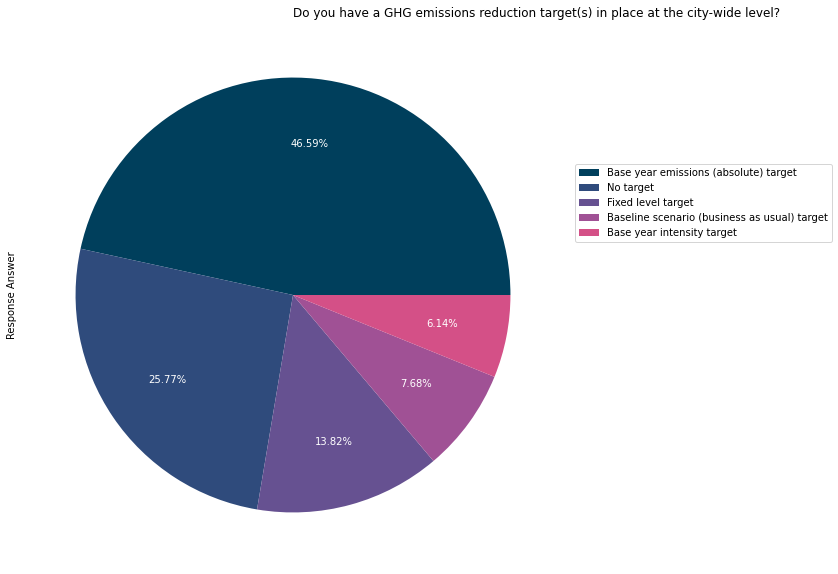

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Do not know' 'No' 'Question not applicable' nan 'Yes']


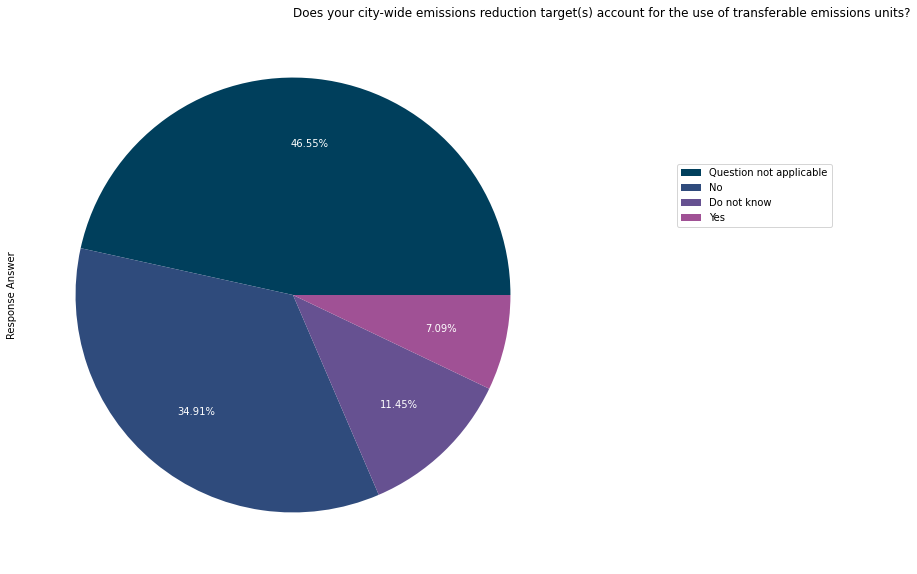

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Yes' 'No' 'Question not applicable' 'Do not know' nan]


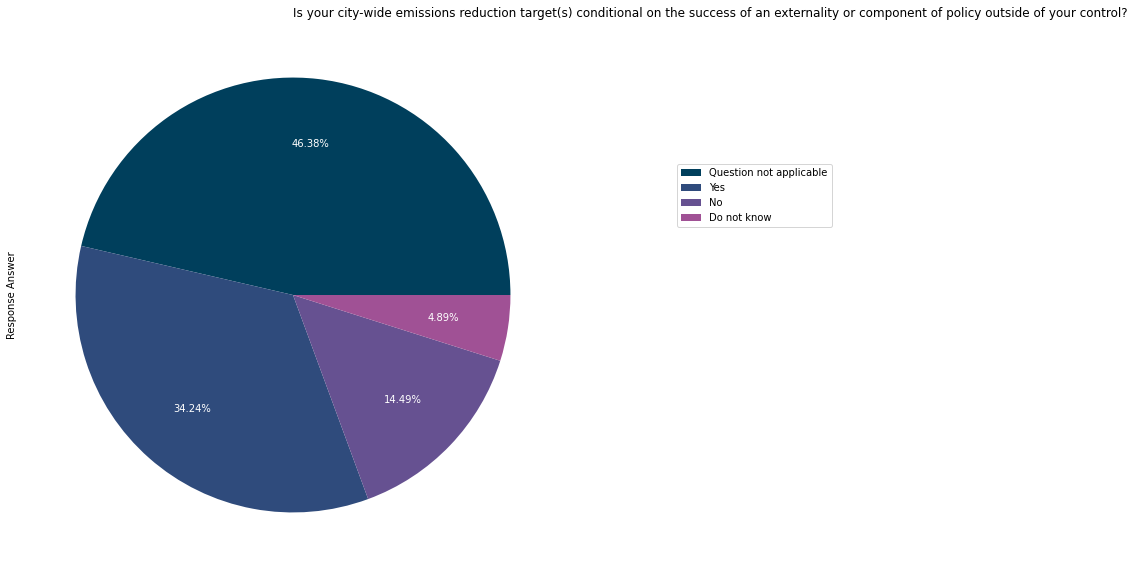

The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
['Yes' 'In progress' 'Intending to undertake in the next 2 years'
 'Do not know' 'Not intending to undertake' nan]


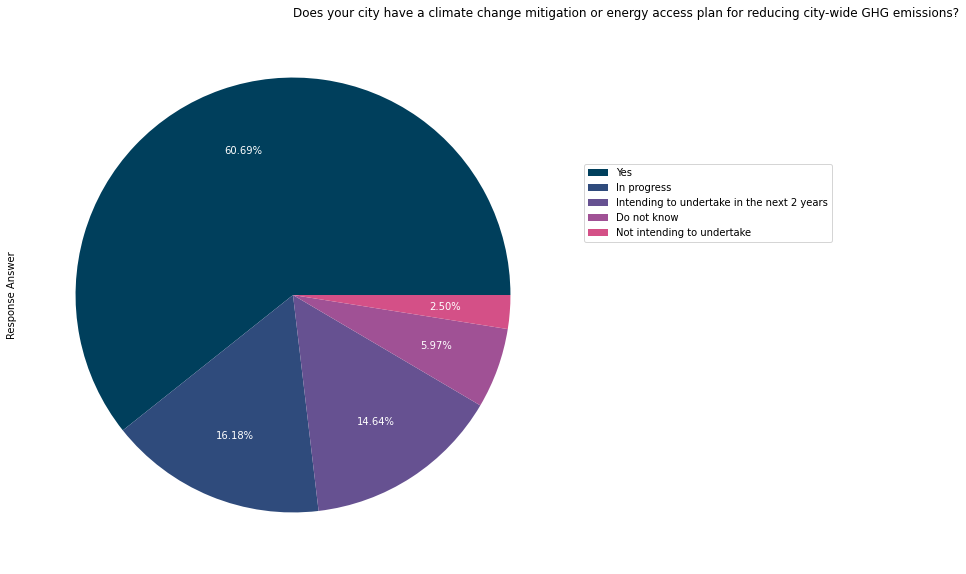

In [124]:
for parent_name in list_parent_section:
    df_parent = select_parent_section(cities_df, parent_name)
    question_list = df_parent['Question Name'].unique()
    for i, question in enumerate(question_list):
        answer = define_answer(question, df_parent)
        if len(answer)!=0:
            
            savefig_path = SAVE_PATH+parent_name+'/'
            savefig_name = str(i)+".jpeg"
            savefig_fullpath = savefig_path+savefig_name
            if not os.path.isdir(savefig_path):
                os.makedirs(savefig_path) 
            plot(answer, colors, savefig_fullpath)

In [68]:
question_list = cwe['Question Name'].unique()
question_list

array(['The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.',
       'Please provide a summary of emissions factors and activity data used in your inventory.',
       'Does your city have a strategy, or other policy document, in place for how to measure and reduce consumption-based GHG emissions in your city?',
       'Which gases are included in your city-wide emissions inventory?',
       'Please provide details on any historical and base year city-wide emissions inventories your city has, in order to allow assessment of targets in the table below.',
       'Please provide a summary of emissions by sector and scope as defined in the Global Protocol f

In [69]:
question_list[0]

'The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.'

### 'The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.'

In [83]:
def define_answer(question_list, num, cwe):
    quest = question_list[num]
    select = select_question(cwe, quest)
    answer = select['Response Answer']
    print(quest)
    print(len(answer.unique()))
    if len(answer.unique())<30:
        print(quest)
        print(answer.unique())
    return answer

In [84]:
#for parent in parent_section:
for i, _ in enumerate(question_list):
    answer = define_answer(question_list, i, cwe)


The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. Please provide a breakdown of your city-wide emissions by sector and sub-sector in the table below. Where emissions data is not available, please use the relevant notation keys to explain the reason why.
5794
Please provide a summary of emissions factors and activity data used in your inventory.
4138
Does your city have a strategy, or other policy document, in place for how to measure and reduce consumption-based GHG emissions in your city?
112
Which gases are included in your city-wide emissions inventory?
9
['HFCs' 'CO2' 'N20' 'PFCs' 'Question not applicable' 'CH4' 'NF3' nan 'SF6']
Please provide details on any historical and base year city-wide emissions inventories your city has, in order to allow assessment of targets in the table below.
1411
Please provide a summary of emissions by sector and sc

### Which gases are included in your city-wide emissions inventory?

In [67]:
quest = 'Which gases are included in your city-wide emissions inventory?'
which_gas = select_question(cwe, quest)
which_gas['Response Answer'].unique()

array([nan, 'Question not applicable', 'Not Occurring', ..., '14817',
       '852', '815970'], dtype=object)

In [64]:
answer = select_question(cwe, quest)['Response Answer']

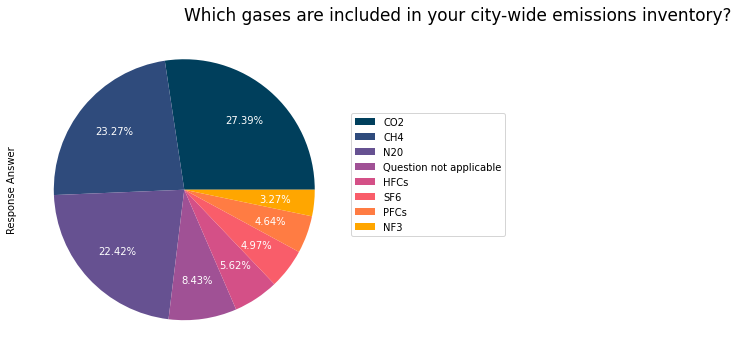

In [65]:
answer.value_counts().plot.pie(textprops={'color':"w"},pctdistance=0.7,autopct='%.2f%%',figsize=(6,6),colors=colors, labels=None)
plt.title(quest,fontsize=17,ha='left')
plt.legend(labels=answer.value_counts().index, loc="best",bbox_to_anchor=(1, 0.25, 0.5, 0.5))
plt.show()

### Does your city have a city-wide emissions inventory to report?

In [56]:
quest ='Does your city have a city-wide emissions inventory to report?'
select_question(cwe, quest)['Response Answer'].unique()

array(['Yes', 'In progress', nan,
       'Intending to undertake in the next 2 years',
       'Not intending to undertake'], dtype=object)

In [57]:
answer = select_question(cwe, quest)['Response Answer']

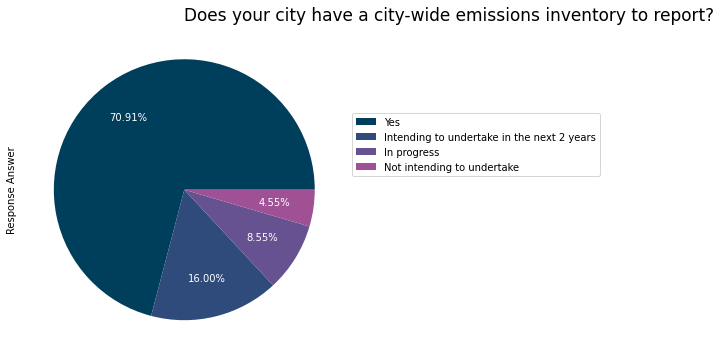

In [60]:
answer.value_counts().plot.pie(textprops={'color':"w"},pctdistance=0.7,autopct='%.2f%%',figsize=(6,6),colors=colors, labels=None)
plt.title(quest,fontsize=17,ha='left')
plt.legend(labels=answer.value_counts().index, loc="best",bbox_to_anchor=(1, 0.25, 0.5, 0.5))
plt.show()

### Where it will facilitate a greater understanding of your\u202fcity-wide\u202femissions, please provide a breakdown of these emissions by end user (buildings, water, waste, transport), economic sector (residential, commercial, industrial, institutional), or any other classification system used in your city.

In [42]:
quest = 'Where it will facilitate a greater understanding of your\u202fcity-wide\u202femissions, please provide a breakdown of these emissions by end user (buildings, water, waste, transport), economic sector (residential, commercial, industrial, institutional), or any other classification system used in your city.'
select = select_question(cwe, quest)['Response Answer']
select.unique()

array(['Question not applicable', 'Heating Oil', nan, '24618.38',
       'Stationary energy (buildings)', '425941', 'Transportation',
       '21580', 'Other, please specify: Waste and Wastwater',
       'Total figure', 'Gasoline and diesel', '521570',
       "Industry, oil and gas. This sector includes greenhouse gas emissions from oil and gas extraction, industry and mining. The sector includes many companies subject to quotas. Emissions from oil and gas extraction account for more than 50 per cent of the sector's emissions and are mainly found on the continental shelf. Activities on the continental shelf fall outside the municipal distribution emissions, and is not included in the greenhouse gas accounts for municipalities. However, there are also some onshore facilities in this industry, and emissions from these are distributed to the municipalities where the facilities are located. This applies to emissions from combustion, processes and evaporation from facilities for receiving an

In [43]:
len(select)

2752

In [44]:
common_words = get_top_n_words(cwe['Response Answer'], 50)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['word' , 'count'])

fig = px.bar(df1, x='word', y='count')
fig.update_layout(title_text='Response_Answer word count top 20', template="plotly_white")
fig.show()

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [45]:
cwe['Response Answer'] = cwe['Response Answer'].fillna('No Response')

for i in range(1,7):
    common_words = get_top_n_bigram(cwe['Response Answer'], 30, i)
    for word, freq in common_words:
        print(word, freq)
    df2 = pd.DataFrame(common_words, columns = ['word' , 'count'])
    fig = px.bar(df2, x='word', y='count')
    fig.update_layout(title_text='Answers bigram count top 20', template="plotly_white")
    fig.show()

<ipython-input-45-cc8f2b9856dc>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



applicable 81418.5944568713
question 81405.38156608999
response 52751.14039496174
estimated 4704.389036133569
occurring 3293.5326080875157
emissions 2326.9258587120135
direct 1855.4208205632194
integrated 1551.7259974865044
co2e 1172.4686498941296
crf 1076.2736380741048
yes 1048.3007949400494
01 1012.1854106649139
scope 978.5045363536253
tonne 891.7199835938064
ch4 828.1044057209817
kg 759.8995363059985
energy 736.353804169626
ipcc 731.6472225986338
gas 726.2425892183334
kilogram 706.2749314133965
n20 682.6511114006821
indirect 632.1932637463282
electricity 626.9601779140074
12 606.1199117203964
31 604.8512139298217
buildings 572.7441402545817
stationary 562.2733959768833
city 562.1929344638475
specify 545.270470471024
co2 530.4361950382058


question applicable 115124.0
direct emissions 2016.0613628348156
kilogram kg 969.0
01 01 633.676661184596
12 31 609.0801388755419
scope indirect 588.9851256294455
stationary energy 545.1156471975125
total emissions 511.6879871468408
crf stationary 495.7664540595289
intending undertake 469.1261068122348
crf transportation 465.61878518508956
scope direct 461.58050751221765
greenhouse gas 364.9413395222395
transportation road 363.68094732413505
diesel oil 334.3201087230201
buildings facilities 312.1607085263728
natural gas 299.9332124762626
gas emissions 266.83015901247836
residential buildings 260.42123402459225
grid supplied 256.7517203485639
covers entire 253.76677385788523
entire city 252.76107699456372
energy residential 234.2975953841722
indirect emissions 216.10577512555162
community greenhouse 211.0886177915942
emissions inventories 209.6265430833855
global protocol 209.0400996026754
protocol community 208.9357591434458
supplied electricity 208.68948738689932
inventories gpc 208.2

crf stationary energy 538.8638740410798
crf transportation road 496.0548561318512
covers entire city 356.79128585624966
greenhouse gas emissions 278.5146344032874
stationary energy residential 260.8449442860333
energy residential buildings 260.6399612150048
intending undertake years 229.0
community greenhouse gas 223.20404312893314
grid supplied electricity 221.34583714683296
global protocol community 220.99397302283924
indirect emissions use 220.09762152788278
emissions use grid 219.97536575790673
use grid supplied 219.96194593812533
supplied electricity heat 219.96194593812533
electricity heat steam 219.96194593812533
heat steam cooling 219.96194593812533
gas emissions inventories 219.55274903616504
emissions inventories gpc 219.53565019561742
protocol community greenhouse 219.46736140647002
motor gasoline petrol 173.12420533181032
commercial buildings facilities 163.77320949000074
liquefied petroleum gas 163.36526035438982
2018 12 31 162.0
2017 12 31 160.0
2018 01 01 158.0
2017 01 0

stationary energy residential buildings 305.2467996455891
crf stationary energy residential 304.4466720223852
community greenhouse gas emissions 238.6384778374818
greenhouse gas emissions inventories 237.47884734685996
gas emissions inventories gpc 237.46538770047425
indirect emissions use grid 237.45959118639314
emissions use grid supplied 237.45959118639314
use grid supplied electricity 237.44378789596888
grid supplied electricity heat 237.44378789596888
supplied electricity heat steam 237.44378789596888
electricity heat steam cooling 237.44378789596888
global protocol community greenhouse 237.41810620826473
protocol community greenhouse gas 237.41810620826473
ipcc 5th ar 2013 213.0
industrial process product use 188.35989745054508
stationary energy commercial buildings 158.3240256595171
stationary energy industrial buildings 156.43671529636208
energy industrial buildings facilities 156.34287890697786
energy commercial buildings facilities 156.15378918799644
crf stationary energy ind

crf stationary energy residential buildings 428.7132901175165
greenhouse gas emissions inventories gpc 265.2631228373443
global protocol community greenhouse gas 265.24568073569486
protocol community greenhouse gas emissions 265.24568073569486
community greenhouse gas emissions inventories 265.24568073569486
indirect emissions use grid supplied 260.1040878758105
emissions use grid supplied electricity 260.1040878758105
use grid supplied electricity heat 260.0832449040586
grid supplied electricity heat steam 260.0832449040586
supplied electricity heat steam cooling 260.0832449040586
agriculture forestry land use sectors 192.07133453164678
stationary energy industrial buildings facilities 191.27554451504793
crf stationary energy industrial buildings 191.0546758500931
stationary energy commercial buildings facilities 190.81734998487045
crf stationary energy commercial buildings 190.3023969741372
guidelines national greenhouse gas inventories 118.44816574518775
ipcc guidelines national gre

global protocol community greenhouse gas emissions 306.1224148331774
protocol community greenhouse gas emissions inventories 306.1224148331774
community greenhouse gas emissions inventories gpc 306.1224148331774
indirect emissions use grid supplied electricity 290.77710797359
emissions use grid supplied electricity heat 290.77710797359
use grid supplied electricity heat steam 290.74900736881784
grid supplied electricity heat steam cooling 290.74900736881784
crf stationary energy industrial buildings facilities 270.0
crf stationary energy commercial buildings facilities 269.0
environmental protection administration executive yuan taiwan 154.54824298035706
ipcc guidelines national greenhouse gas inventories 142.2515922062938
2006 ipcc guidelines national greenhouse gas 141.6672652627757
cfr stationary energy institutional buildings facilities 103.0
emissions occurring outside city boundary result 102.68269768789874
occurring outside city boundary result city 102.68269768789874
outside ci

In [46]:
# Investigate crf stationary energy industrial/residential buildings
305.2467996455891/len(select)*100

11.091816847586813

### 'Please indicate the category that best describes the boundary of your city-wide GHG emissions inventory.'

In [57]:
quest = 'Please indicate the category that best describes the boundary of your city-wide GHG emissions inventory.'
select_question(cwe, quest)['Response Answer'].unique()

array(['Question not applicable', 'No Response', 'Not applicable',
       'Larger – covers the whole city and adjoining areas',
       'Corporate emissions for the municipality',
       'Same – covers entire city and nothing else',
       '-Los sumideros como parques y jardines.-Áreas verdes de malecones.',
       'La Huella de Carbono del cantón de Loja fue de 423.878 ton CO2e para el año 2015, equivalente al CO2 que absorben 1.412.926 árboles en un periodo de 10 años . Los sectores con mayor aporte a la HC de Loja son el de transporte (67%), seguido del sector de residencial (16%) y residuos (9%). Finalmente los sectores comercial/industrial (5%), e industrial (3%) sumados aportan cerca al 8% del total de la Huella.',
       'The administrative boundary of the Greater London Authority, which encompasses the 33 local authorities in London',
       'não se aplica',
       'The GHGEI excludes scope 3 emissions (particularly AFOLU and Industrial Processes and Product Use )',
       'El i

## Quantification

- How many cities in 2018, 2019 and 2020
- The final report and notebook could be like:
    1. Introduction / 2. Data validation
    2. City-wide emissions
    3. ....
    7. Emission reduction
    8. Correlation / K-means clustering between different parents sections

Which file have the data location of the city ? (lon, lat)

Colocate lon, lat of cities with external dataset from WHO to add additional support

Data Visualisation